<a href="https://colab.research.google.com/github/Lakshmanaraja/Teaching-Deep-Learning/blob/main/DCGan_CelebA_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import os
import pathlib
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

import time

import random

In [3]:
creds =' {"username":"lakshmanarajak","key":"e88bdc2a58e339ce6863757a660f81ce"}'  

cred_path = pathlib.Path('~/.kaggle/kaggle.json').expanduser()
print(cred_path)
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

/root/.kaggle/kaggle.json


In [4]:
from kaggle import api

In [5]:
!kaggle datasets download -d lakshmanarajak/celeba-torchvision-dataset

 99% 1.32G/1.34G [00:06<00:00, 191MB/s]
100% 1.34G/1.34G [00:07<00:00, 203MB/s]


In [6]:
from zipfile import ZipFile

with ZipFile('/content/celeba-torchvision-dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall('./data/celeba')
   print('File is unzipped in  folder') 

File is unzipped in  folder


In [7]:
BATCH_SIZE = 128
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64

In [8]:
#Dataset , DataLoader and Transformations

custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((160, 160)),
    torchvision.transforms.Resize([IMAGE_HEIGHT, IMAGE_WIDTH]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


#Remember to change sub folder img_align_celeba to main folder
train_dataset = datasets.CelebA(root='/content/data/', download=False, transform=custom_transforms )
train_loader =  torch.utils.data.DataLoader( dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
#Checking the Dataset

  # Checking the dataset
  print('Training Set:\n')
  for images, labels in train_loader:  
      print('Image batch dimensions:', images.size())
      print('Image label dimensions:', labels.size())
      #print(labels[:10])
      break
      
# # Checking the dataset
# print('\nValidation Set:')
# for images, labels in valid_loader:  
#     print('Image batch dimensions:', images.size())
#     print('Image label dimensions:', labels.size())
#     #print(labels[:10])
#     break

# # Checking the dataset
# print('\nTesting Set:')
# for images, labels in test_loader:  
#     print('Image batch dimensions:', images.size())
#     print('Image label dimensions:', labels.size())
#     #print(labels[:10])
#     break

Training Set:

Image batch dimensions: torch.Size([128, 3, 64, 64])
Image label dimensions: torch.Size([128, 40])


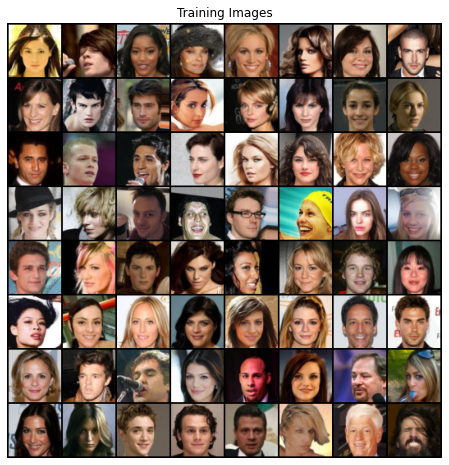

In [10]:
plt.figure(figsize =(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64],padding=2,normalize=True),(1,2,0)))

# **MODEL**

In [11]:
def _conv_block(in_channels,out_channels,kernel_size=4,stride=2,padding=1,transpose= False):
       
        if transpose == True :
                layers= [ nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
                              nn.BatchNorm2d(out_channels), nn.LeakyReLU(0.2)]
        else:
                layers = [nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
                         nn.BatchNorm2d(out_channels),
                         nn.ReLU() ]
        return nn.Sequential(*layers)

In [12]:
from torch.nn.modules.activation import Sigmoid
from torch.nn.modules.batchnorm import BatchNorm2d
#Model

class Discriminator(nn.Module):
  
  def __init__(self,no_image_channels,features_d):
    super(Discriminator,self).__init__()
    #self.disc_block = []

    self.initialconv = nn.Sequential(nn.Conv2d(no_image_channels,features_d,kernel_size=4,stride = 2, padding = 1 , bias = False), 
                                     nn.ReLU())  #Padding = 0 Stride = 1
    self.conv_block1 =  _conv_block(features_d , features_d*2,kernel_size = 4, 
                                                 stride = 2, padding = 1)
    self.conv_block2 = _conv_block(features_d*2 , features_d*4,kernel_size = 4, 
                                                 stride = 2, padding = 1)
    
    self.conv_block3 = _conv_block(features_d*4 , features_d*8,kernel_size = 4, 
                                                 stride = 2, padding = 1)
                                    

    #No BatchNorm and No padding. stride = 1
    self.final_block =  nn.Sequential(nn.Conv2d(features_d*8,1 ,kernel_size=4,
                                               stride = 2, padding = 0 , bias = False),nn.Sigmoid())  
    self.disc_block = nn.Sequential(self.initialconv ,self.conv_block1,self.conv_block2,self.conv_block3,self.final_block)
                                    

  def forward(self,x):
    return self.disc_block(x) #??
     
  



In [13]:
class Generator(nn.Module):

  def __init__(self,Z_dim,no_of_image_channels,features_g):
    super(Generator,self).__init__()

    self.conv_block = nn.Sequential(_conv_block(Z_dim,features_g*8,kernel_size=4,stride = 1, padding= 0,transpose = True),
                                    _conv_block(features_g*8,features_g*4,kernel_size=4,stride=2,padding=1,transpose = True),
                                    _conv_block(features_g*4,features_g*2,kernel_size=4,stride=2,padding=1,transpose = True),
                                    _conv_block(features_g*2,features_g,kernel_size=4,stride=2,padding=1,transpose = True),
    )

    self.final_block = nn.Sequential(nn.ConvTranspose2d(features_g,no_of_image_channels,kernel_size=4,stride=2,padding=1),
                                     nn.Tanh())
    self.gen_block = nn.Sequential(self.conv_block,self.final_block)

  def forward(self,x):
    return self.gen_block(x)




In [14]:
def initialize_weights(model):
        for m in model.modules():
            if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d,nn.BatchNorm2d)):
                nn.init.normal_(m.weight.data,0.0,0.2)


In [15]:
def test():
        m,in_channels,height,width = 2,3,64,64
        z_dim = 100
        x = torch.randn(2,3,64,64)
        model = Discriminator(in_channels,8)
        initialize_weights(model)
        print(model.disc_block)
        yhat = model(x)
        print(yhat.shape)
        assert(yhat.shape == (m,1,1,1)) 
        gen = Generator(z_dim, in_channels, 8)
        print(gen.gen_block)
        z = torch.randn((m, z_dim, 1, 1))
        zhat =  gen(z)
        print (zhat.shape)
        assert zhat.shape == (m, in_channels, height, width) 
        print("all assertion over")
test()
  

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (4): Sequential(
    (0): Conv2d(64, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): Sigmoid()
  )
)
torch.Size([2, 1, 1, 1])
Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(10

In [32]:
#Model-Optimizer-Loss Function
NO_OF_EPOCHS = 20
LEARNING_RATE = 0.0002
Z_dim = 100
FEATURE_D = 8
FEATURE_G = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE_HEIGHT= 64
IMAGEA_SIZE_WIDTH= 64
RANDOM_SEED = 42
disc = Discriminator(3,8).to(DEVICE)
gen = Generator(Z_dim,3,8).to(DEVICE)
optimizer_disc = torch.optim.Adam( disc.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
optimizer_gen = torch.optim.Adam( gen.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))

criterion = nn.BCELoss()



In [31]:
def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.set_deterministic(True)
    
    
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_deterministic
set_all_seeds(RANDOM_SEED)

In [ ]:
#Training - Loop

log_dict = {'train_generator_loss_per_batch': [],
                'train_discriminator_loss_per_batch': [],
                'train_discriminator_real_acc_per_batch': [],
                'train_discriminator_fake_acc_per_batch': [],
                'images_from_noise_per_epoch': []}


fixed_noise = torch.randn(64, Z_dim, 1, 1, device=DEVICE) # format NCHW

start_time = time.time()

for epoch in range(NO_OF_EPOCHS):

    for batchidx,(real_image,_) in enumerate(train_loader):

      current_batch_size =   real_image.size(0)
      optimizer_disc.zero_grad()

      real_image = real_image.to(DEVICE)
      noise = torch.randn(current_batch_size, Z_dim, 1,1,device=DEVICE)
      fake_image = gen(noise).to(DEVICE)

      real_labels = torch.ones(current_batch_size, device = DEVICE)
      fake_labels = torch.zeros(current_batch_size, device = DEVICE)
      flipped_labels = real_labels

      #Training Discriminator

      real_pred = disc(real_image).view(-1)
      real_loss = criterion(real_pred,real_labels)

      fake_pred = disc(fake_image.detach()).view(-1)
      fake_loss = criterion(fake_pred,fake_labels)

      disc_loss = (real_loss + fake_loss)*0.5
      disc_loss.backward()

      optimizer_disc.step()

      #Training Generator

      optimizer_gen.zero_grad()

      fake_pred_gen = disc(fake_image).view(-1)
      gen_loss = criterion(fake_pred_gen,flipped_labels)

      gen_loss.backward()
      optimizer_gen.step()

      # --------------------------
              # Logging
      # --------------------------   
      log_dict['train_generator_loss_per_batch'].append(gen_loss.item())
      log_dict['train_discriminator_loss_per_batch'].append(disc_loss.item())
      
      predicted_labels_real = torch.where(real_pred.detach() > 0., 1., 0.)
      predicted_labels_fake = torch.where(fake_pred_gen.detach() > 0., 1., 0.)
      acc_real = (predicted_labels_real == real_labels).float().mean()*100.
      acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
      log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
      log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())         
      
      if not batchidx % 100:
        print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                % (epoch+1, NO_OF_EPOCHS, batchidx, 
                  len(train_loader), gen_loss.item(), disc_loss.item()))
        
                ### Save images for evaluation
    with torch.no_grad():
            fake_images = gen(fixed_noise).detach().cpu()
            log_dict['images_from_noise_per_epoch'].append(
                torchvision.utils.make_grid(fake_images, padding=2, normalize=True))


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    
#if save_model is not None:
  #  torch.save(model.state_dict(), save_model)
    
#return log_dict


    

Epoch: 001/020 | Batch 000/1272 | Gen/Dis Loss: 0.7737/0.7466
Epoch: 001/020 | Batch 100/1272 | Gen/Dis Loss: 3.3595/0.0697
Epoch: 001/020 | Batch 200/1272 | Gen/Dis Loss: 4.6804/0.0293
Epoch: 001/020 | Batch 300/1272 | Gen/Dis Loss: 4.0428/0.0493
Epoch: 001/020 | Batch 400/1272 | Gen/Dis Loss: 4.0298/0.0947
Epoch: 001/020 | Batch 500/1272 | Gen/Dis Loss: 3.8174/0.1386
Epoch: 001/020 | Batch 600/1272 | Gen/Dis Loss: 3.0021/0.1794
Epoch: 001/020 | Batch 700/1272 | Gen/Dis Loss: 2.7731/0.1544
Epoch: 001/020 | Batch 800/1272 | Gen/Dis Loss: 2.8926/0.2018
Epoch: 001/020 | Batch 900/1272 | Gen/Dis Loss: 2.4473/0.3122
Epoch: 001/020 | Batch 1000/1272 | Gen/Dis Loss: 1.9016/0.3113
Epoch: 001/020 | Batch 1100/1272 | Gen/Dis Loss: 1.8661/0.2828
Epoch: 001/020 | Batch 1200/1272 | Gen/Dis Loss: 2.1600/0.2325
Time elapsed: 5.62 min
Epoch: 002/020 | Batch 000/1272 | Gen/Dis Loss: 2.1068/0.2700
Epoch: 002/020 | Batch 100/1272 | Gen/Dis Loss: 1.8736/0.3034
Epoch: 002/020 | Batch 200/1272 | Gen/Dis Lo

In [24]:
import matplotlib.colors as mcolors

In [ ]:
def plot_multiple_training_losses(losses_list, num_epochs, 
                                  averaging_iterations=100, custom_labels_list=None):

    for i,_ in enumerate(losses_list):
        if not len(losses_list[i]) == len(losses_list[0]):
            raise ValueError('All loss tensors need to have the same number of elements.')
    
    if custom_labels_list is None:
        custom_labels_list = [str(i) for i,_ in enumerate(custom_labels_list)]
    
    iter_per_epoch = len(losses_list[0]) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    
    for i, minibatch_loss_tensor in enumerate(losses_list):
        ax1.plot(range(len(minibatch_loss_tensor)),
                 (minibatch_loss_tensor),
                  label=f'Minibatch Loss{custom_labels_list[i]}')
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Loss')

        ax1.plot(np.convolve(minibatch_loss_tensor,
                             np.ones(averaging_iterations,)/averaging_iterations,
                             mode='valid'),
                 color='black')
    
    if len(losses_list[0]) < 1000:
        num_losses = len(losses_list[0]) // 2
    else:
        num_losses = 1000
    maxes = [np.max(losses_list[i][num_losses:]) for i,_ in enumerate(losses_list)]
    ax1.set_ylim([0, np.max(maxes)*1.5])
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()


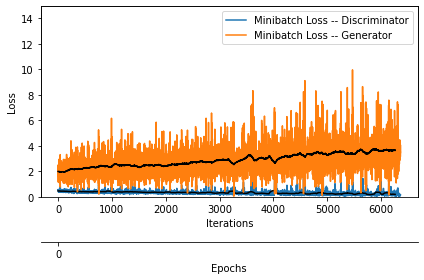

In [27]:
plot_multiple_training_losses(
    losses_list=(log_dict['train_discriminator_loss_per_batch'],
                 log_dict['train_generator_loss_per_batch']),
    num_epochs=NO_OF_EPOCHS, 
    custom_labels_list=(' -- Discriminator', ' -- Generator')
)  

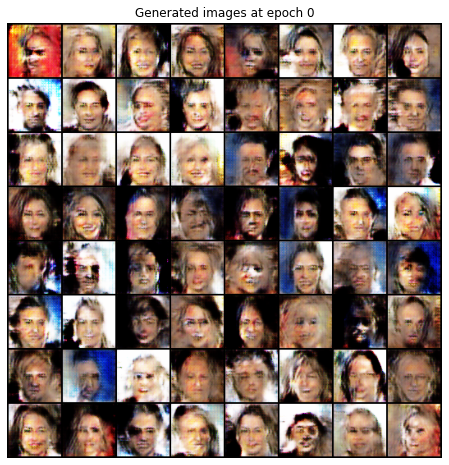

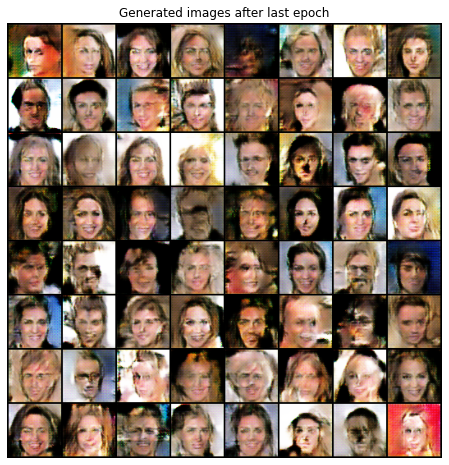

In [28]:
##########################
### VISUALIZATION
##########################

for i in range(0, NO_OF_EPOCHS, 5):
    
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()
    
    
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()

In [ ]:
# Epoch: 001/005 | Batch 000/1272 | Gen/Dis Loss: 1.6847/0.5450
# Epoch: 001/005 | Batch 100/1272 | Gen/Dis Loss: 1.0722/0.4773
# Epoch: 001/005 | Batch 200/1272 | Gen/Dis Loss: 1.9695/0.4104
# Epoch: 001/005 | Batch 300/1272 | Gen/Dis Loss: 3.0707/0.4311
# Epoch: 001/005 | Batch 400/1272 | Gen/Dis Loss: 1.8559/0.3591
# Epoch: 001/005 | Batch 500/1272 | Gen/Dis Loss: 2.2252/0.4401
# Epoch: 001/005 | Batch 600/1272 | Gen/Dis Loss: 1.5821/0.4065
# Epoch: 001/005 | Batch 700/1272 | Gen/Dis Loss: 1.7426/0.3907
# Epoch: 001/005 | Batch 800/1272 | Gen/Dis Loss: 1.8732/0.3673
# Epoch: 001/005 | Batch 900/1272 | Gen/Dis Loss: 1.9569/0.4055
# Epoch: 001/005 | Batch 1000/1272 | Gen/Dis Loss: 2.5533/0.5584
# Epoch: 001/005 | Batch 1100/1272 | Gen/Dis Loss: 1.9615/0.3649
# Epoch: 001/005 | Batch 1200/1272 | Gen/Dis Loss: 2.5076/0.3780
# Time elapsed: 5.58 min
# Epoch: 002/005 | Batch 000/1272 | Gen/Dis Loss: 2.4344/0.2804
# Epoch: 002/005 | Batch 100/1272 | Gen/Dis Loss: 3.8047/0.2728
# Epoch: 002/005 | Batch 200/1272 | Gen/Dis Loss: 3.5362/0.5229
# Epoch: 002/005 | Batch 300/1272 | Gen/Dis Loss: 1.6986/0.4197
# Epoch: 002/005 | Batch 400/1272 | Gen/Dis Loss: 2.6071/0.4106
# Epoch: 002/005 | Batch 500/1272 | Gen/Dis Loss: 2.7647/0.4566
# Epoch: 002/005 | Batch 600/1272 | Gen/Dis Loss: 3.4989/0.2799
# Epoch: 002/005 | Batch 700/1272 | Gen/Dis Loss: 2.3625/0.2681
# Epoch: 002/005 | Batch 800/1272 | Gen/Dis Loss: 2.8083/0.1980
# Epoch: 002/005 | Batch 900/1272 | Gen/Dis Loss: 1.4448/0.3373
# Epoch: 002/005 | Batch 1000/1272 | Gen/Dis Loss: 2.7410/0.2437
# Epoch: 002/005 | Batch 1100/1272 | Gen/Dis Loss: 2.3804/0.2539
# Epoch: 002/005 | Batch 1200/1272 | Gen/Dis Loss: 2.2739/0.2713
# Time elapsed: 11.17 min
# Epoch: 003/005 | Batch 000/1272 | Gen/Dis Loss: 1.8314/0.2975
# Epoch: 003/005 | Batch 100/1272 | Gen/Dis Loss: 3.5813/0.2632
# Epoch: 003/005 | Batch 200/1272 | Gen/Dis Loss: 1.9043/0.3335
# Epoch: 003/005 | Batch 300/1272 | Gen/Dis Loss: 2.3224/0.2763
# Epoch: 003/005 | Batch 400/1272 | Gen/Dis Loss: 2.3616/0.2321
# Epoch: 003/005 | Batch 500/1272 | Gen/Dis Loss: 2.3149/0.3178
# Epoch: 003/005 | Batch 600/1272 | Gen/Dis Loss: 1.7508/0.2384
# Epoch: 003/005 | Batch 700/1272 | Gen/Dis Loss: 2.5909/0.2683
# Epoch: 003/005 | Batch 800/1272 | Gen/Dis Loss: 2.2029/0.3226
# Epoch: 003/005 | Batch 900/1272 | Gen/Dis Loss: 1.3789/0.6916
# Epoch: 003/005 | Batch 1000/1272 | Gen/Dis Loss: 3.3743/0.2082
# Epoch: 003/005 | Batch 1100/1272 | Gen/Dis Loss: 4.6014/0.7802
# Epoch: 003/005 | Batch 1200/1272 | Gen/Dis Loss: 1.6127/0.3258
# Time elapsed: 16.77 min
# Epoch: 004/005 | Batch 000/1272 | Gen/Dis Loss: 1.7106/0.3988
# Epoch: 004/005 | Batch 100/1272 | Gen/Dis Loss: 2.0507/0.3254
# Epoch: 004/005 | Batch 200/1272 | Gen/Dis Loss: 1.3909/0.4117
# Epoch: 004/005 | Batch 300/1272 | Gen/Dis Loss: 2.7192/0.2573
# Epoch: 004/005 | Batch 400/1272 | Gen/Dis Loss: 1.7938/0.4489
# Epoch: 004/005 | Batch 500/1272 | Gen/Dis Loss: 3.6288/0.3178
# Epoch: 004/005 | Batch 600/1272 | Gen/Dis Loss: 3.4522/0.1715
# Epoch: 004/005 | Batch 700/1272 | Gen/Dis Loss: 3.5827/0.1815
# Epoch: 004/005 | Batch 800/1272 | Gen/Dis Loss: 2.6445/0.2473
# Epoch: 004/005 | Batch 900/1272 | Gen/Dis Loss: 3.1766/0.1814
# Epoch: 004/005 | Batch 1000/1272 | Gen/Dis Loss: 4.9727/0.3127
# Epoch: 004/005 | Batch 1100/1272 | Gen/Dis Loss: 5.3066/0.4778
# Epoch: 004/005 | Batch 1200/1272 | Gen/Dis Loss: 3.5249/0.2033
# Time elapsed: 22.39 min
# Epoch: 005/005 | Batch 000/1272 | Gen/Dis Loss: 2.0054/0.2824
# Epoch: 005/005 | Batch 100/1272 | Gen/Dis Loss: 4.0531/0.1382
# Epoch: 005/005 | Batch 200/1272 | Gen/Dis Loss: 3.2194/0.2333
# Epoch: 005/005 | Batch 300/1272 | Gen/Dis Loss: 3.4298/0.2601
# Epoch: 005/005 | Batch 400/1272 | Gen/Dis Loss: 3.5454/0.2115
# Epoch: 005/005 | Batch 500/1272 | Gen/Dis Loss: 2.3928/0.2406
# Epoch: 005/005 | Batch 600/1272 | Gen/Dis Loss: 2.8935/0.2236
# Epoch: 005/005 | Batch 700/1272 | Gen/Dis Loss: 3.3142/0.2529
# Epoch: 005/005 | Batch 800/1272 | Gen/Dis Loss: 3.7805/0.1418
# Epoch: 005/005 | Batch 900/1272 | Gen/Dis Loss: 0.4745/1.1599
# Epoch: 005/005 | Batch 1000/1272 | Gen/Dis Loss: 2.6344/0.2634
# Epoch: 005/005 | Batch 1100/1272 | Gen/Dis Loss: 3.2371/0.1362
# Epoch: 005/005 | Batch 1200/1272 | Gen/Dis Loss: 4.1063/0.2433
# Time elapsed: 28.00 min
# Total Training Time: 28.00 min